In [1]:
#hide
from covid.core import *

# covid
> Module 

This resource provides a simple wrapper for the covid-19 dastet made available by John Hopkins University (JHU) [here](https://github.com/CSSEGISandData/COVID-19).  Confirmed cases are updated daily in a time series csv [here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv). Daily reports are kept in [this directory](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports) and conform to the format `dd-mm-2020.csv`.

## Install

This code is not yet in PyPI.  The corresponding functions described below are all available in the accompanying `covid` module.

## How to use

You can obtain a time series of confirmed cases globally aggregated by country in a `pandas` dataframe as follows:

In [2]:
df = procTimeSeriesConfirmed()

Let's have a look at the distribution of values.  We should see an equal number of values per country following aggregation:  

In [3]:
print(f'Found {df.shape} (rows,cols) of cols={df.columns.values}')
ddf = df.groupby('country')['confirmed'].count().sort_values(ascending=True)
print(f'max={ddf.max()}, min={ddf.min()}, count={len(ddf)}')

Found (11616, 2) (rows,cols) of cols=['country' 'confirmed']
max=66, min=66, count=176


Now we can plot a time series of confirmed cases in China, Italy, US and UK as follows:

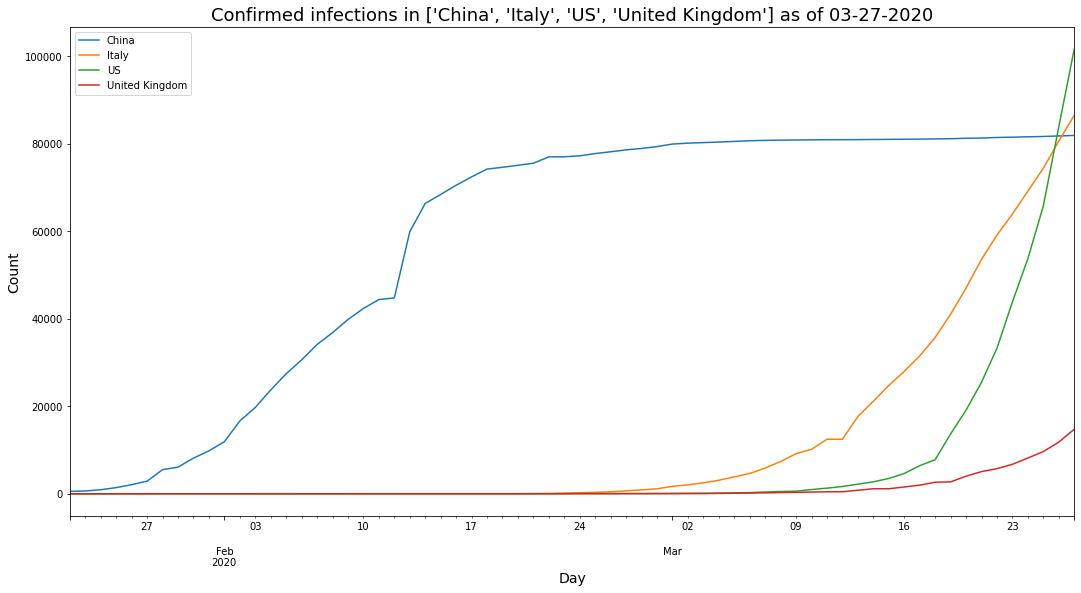

In [4]:
plotCountryTimeSeries(df,['China','Italy','US','United Kingdom'],'Confirmed infections')

And we can plot a time series of recorded deaths in these same countries as follows:

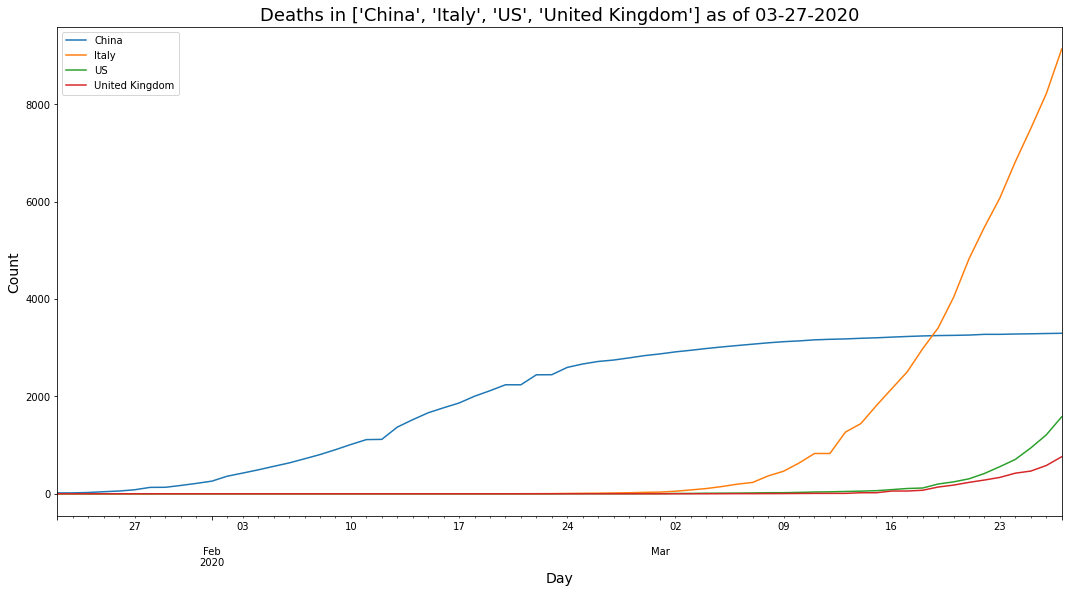

In [5]:
plotCountryTimeSeries(procTimeSeriesDeaths(),['China','Italy','US','United Kingdom'],'Deaths')

## Covid API

I came across an API that nicely wraps up the same JHU dataset and presents it as `json` via a REST API which makes it almost one-liner compliant to go from API call to formatted graph showing cases and deaths by country as follows:

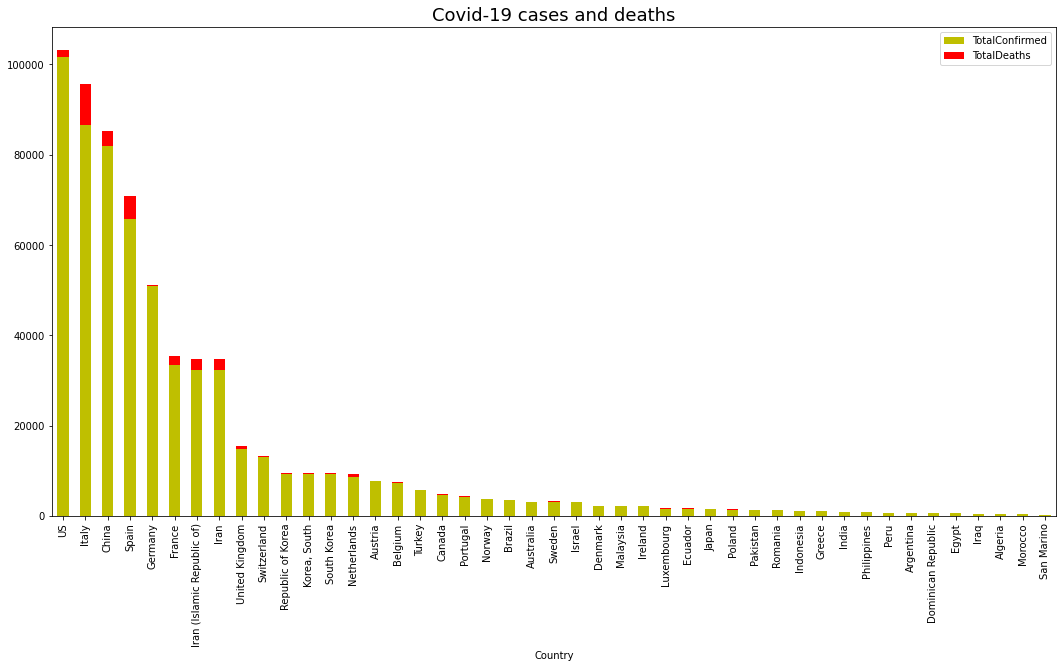

In [6]:
import requests, pandas as pd
df = pd.DataFrame(requests.get('https://api.covid19api.com/summary').json().get('Countries')).sort_values(by=['TotalConfirmed'],ascending=False)
_ = df[df.TotalDeaths > 10].plot(kind='bar',x='Country',y=['TotalConfirmed','TotalDeaths'],\
                                 color='yr',stacked=True,figsize=(18,9)).set_title('Covid-19 cases and deaths',size=18)

It's also possible to do timeseries representation using this API by country:

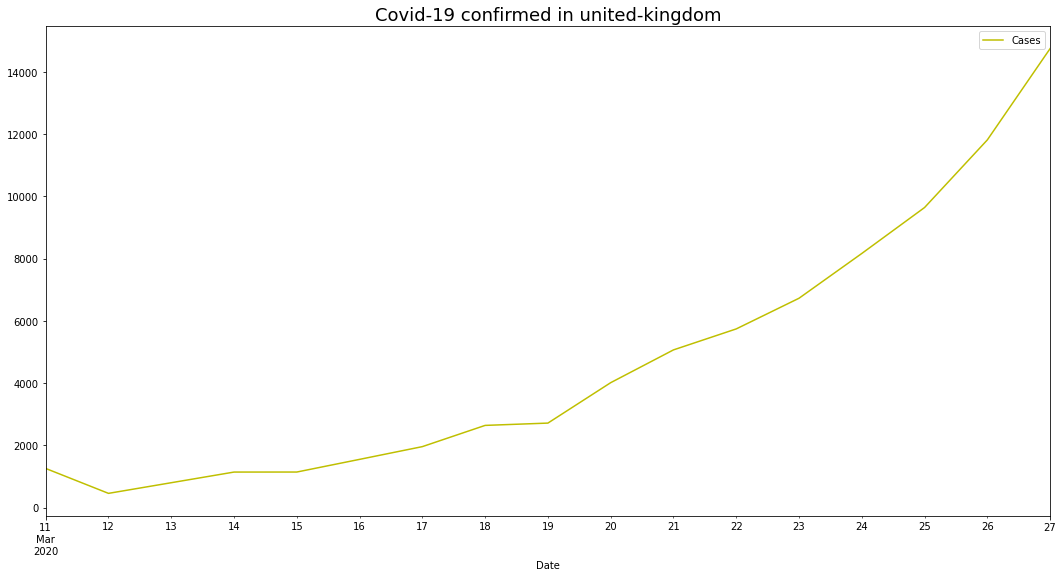

In [7]:
def plotCategoryByCountry(category,country,color='y'):
    df = pd.DataFrame(requests.get(f'https://api.covid19api.com/total/country/{country}/status/{category}').json())
    df['Date'] = df['Date'].apply(pd.to_datetime)
    df.plot(kind='line',x='Date',y='Cases',color=color,figsize=(18,9)).set_title(f'Covid-19 {category} in {country}',size=18)

plotCategoryByCountry('confirmed','united-kingdom')